In [1]:
import numpy as np
import torch
print(torch.__version__)

np.random.seed(42)

0.4.1


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
class Layer:
    def __init__(self):
        pass
    
    def forward(self, input):
        pass
    
    def backward(self, input, grad_output):
        pass

In [4]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        output = torch.max(input, torch.tensor([0.], device=device))
        return output

In [5]:
class LecunTanh(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        output = 1.7159 * torch.tanh(input)
        return output

In [6]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights  = torch.randn(input_units, output_units, device=device)*0.1
        self.biases   = torch.ones(output_units, device=device)
        self.E        = torch.randn(input_units, output_units, device=device) * 2
        
    def forward(self,input):
        return torch.matmul(input, self.weights) + self.biases
    
    def update(self, w_grad, b_grad):
        self.weights = self.weights - self.learning_rate * w_grad
        self.biases  = self.biases - self.learning_rate * b_grad
        self.E       = self.E - self.learning_rate * w_grad

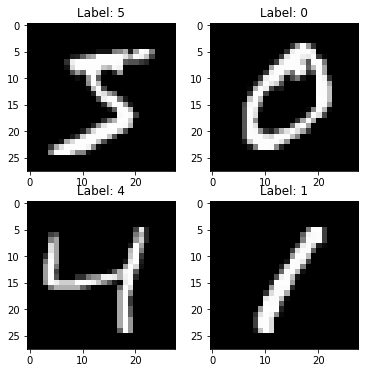

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [8]:
X_train = torch.from_numpy(X_train).float().to(device)
X_val   = torch.from_numpy(X_val).float().to(device)
X_test  = torch.from_numpy(X_test).float().to(device)

In [9]:
def forward(network, X):
    activations = []
    input       = X
    
    for layer in network:
        input = layer.forward(input)
        activations.append(input)
        
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    logits = forward(network, X)[-1]
    return logits.cpu().detach().numpy().argmax(axis=-1)

def normalize(vec, c):
    norm = torch.norm(vec)
    
    if norm >= c:
        return (c * vec) / norm
    else:
        return vec

### LRA-fdbk

In [10]:
from tqdm import trange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [11]:
def train(network, X, y):
    # parameters
    beta = .1
    c1   = 1
    c2   = 1
    K    = 2

    activations = forward(network, X)
    n_layers    = len(network) // 2 + 1
    layer       = n_layers
    l           = len(network)

    h_l         = activations[::2]
    y_l_h       = h_l.copy()
    h_l_hat     = h_l.copy()
    z_l         = [X[:2]] + activations[1::2]
    y_l_z       = z_l.copy()
    z_l_hat     = z_l.copy()

    y_l_z       = z_l.copy() + [torch.from_numpy(y).long().to(device)]

    W_grads     = []
    b_grads     = []

    while layer > 1:
#         print('layer is: {}'.format(layer))

        # lth layer
        W_l = network[l-1].weights
        b_l = network[l-1].biases
        E_l = network[l-1].E

        # final layer
        if l == len(network):
            # final layer ( wx + b )
            scores  = activations[-1]

            # final layer negative log likelihood loss
            loss = torch.functional.F.nll_loss(scores, y_l_z[layer])

            # dL / dz
            m    = y_l_z[layer - 1].shape[0]
            grad = torch.exp(scores) / torch.sum(torch.exp(scores), dim=1)[:, None]
            grad[range(m),y_l_z[layer].long()] -= 1
            grad = grad/m
            
            # dL / dW, dL / db
            W_l_grad = normalize(torch.matmul(torch.transpose(z_l[layer - 1], -1, 0), grad), c1)
            b_l_grad = normalize(torch.matmul(torch.transpose(grad, -1, 0), torch.ones_like(y_l_z[layer]).float()), c1)
            
            W_grads.append(W_l_grad)
            b_grads.append(b_l_grad)

        else:
            # lth layer ( cauchy loss )
#             mse_loss     = torch.nn.MSELoss()
            cauchy_loss  = torch.sum(torch.log(1 + (y_l_z[layer] - z_l[layer])))
            
            # dL / dw, dL / db
            grad     = 1 / ( 1 + (y_l_z[layer] - z_l[layer]) ** 2) * 2 * (y_l_z[layer] - z_l[layer]) * (torch.tanh(h_l[layer - 1]) ** 2 - 1) * 1.7159
            W_l_grad = torch.matmul(torch.transpose(z_l[layer - 1], -1, 0), grad) / len(z_l[layer])          
            W_l_grad = normalize(W_l_grad, c1)
            b_l_grad = normalize(torch.matmul(torch.transpose(grad, -1, 0), 
                                              torch.ones(y_l_z[layer].shape[0], 1, device=device).float()).flatten(), c1) / len(z_l[layer])

            W_grads.append(W_l_grad)
            b_grads.append(b_l_grad)

        
        for k in range(K):
            dh    = grad
            dh    = torch.matmul(grad, torch.transpose(E_l, -1, 0))
            
            # dL / dh(l-1)
            dh_l_1  = normalize(dh, c2)

            h_l_hat[layer-2] = h_l_hat[layer - 2] - beta * dh_l_1            # update h1
            z_l_hat[layer-1] = network[l-2].forward(h_l_hat[layer - 2])      # update z2
            h_l_hat[layer-1] = torch.matmul(z_l_hat[layer - 1], W_l) + b_l   # update h2

        y_l_z[layer - 1] = z_l_hat[layer - 1]                            # update y2
        l     -= 2

        # update to layer
        layer -= 1

    W_grads = W_grads[::-1]
    b_grads = b_grads[::-1]
    
    return W_grads, b_grads

In [12]:
from IPython.display import clear_output
train_log = []
val_log = []

In [13]:
network = []
network.append(Dense(X_train.shape[1], 128))
network.append(LecunTanh())
network.append(Dense(128, 128))
network.append(LecunTanh())
network.append(Dense(128, 128))
network.append(LecunTanh())
network.append(Dense(128, 128))
network.append(LecunTanh())
network.append(Dense(128, 10))

Epoch 24
Train accuracy: 0.95098
Val accuracy: 0.9361


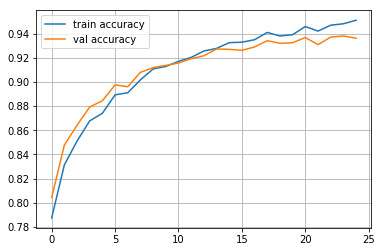

In [14]:
for epoch in range(25):
    batch_count = 0
    
#     print(network[2].weights[:, :10])
        
    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=50, shuffle=True):        
        W_grads, b_grads = train(network, x_batch, y_batch)
        layer    = 0
        
        for l in range(2, len(network), 2):            
            network[l].update(W_grads[layer], b_grads[layer])
            layer += 1
    
#     print(network[2].weights[:, :10])

#     print()
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

In [15]:
# performance on test set
1 - np.mean(predict(network, X_test) == y_test)

0.06769999999999998